Імпортуємо необхідні пакети

In [1]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use('ggplot')  # красиві графіки

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import optimizers
from keras import initializers
from keras import activations
from keras import callbacks

from sklearn.model_selection import train_test_split

#import sys # якщо в Conda не встановлено keras
#!conda install --yes --prefix {sys.prefix} keras

Using TensorFlow backend.


# Корисні функції

In [2]:
# https://stackoverflow.com/questions/33742588/pandas-split-dataframe-by-column-value
# Розділяємо дані по класах, що зазначені у третьому стовпці (для візуалізації)
def separate_by_unique_class(data_arr, unique_class, data_dims):
    return data_arr[data_arr[data_dims] == unique_class]


def add_data_to_plot(x, y):
    plt.plot(x, y, 'o')

def add_dots_to_plot(data_f, data_dimentions:int, data_uniq_cls:list):
    
    # тільки якщо ми маємо справу із двовимірними даними
    if data_dimentions == 2:
        
        # проходимо по всіх унікальних класах 
        for d_cl in data_uniq_cls:
            data = separate_by_unique_class(data_f, d_cl, data_dimentions)
            
            add_data_to_plot(data[0], data[1]) 
    else:
        pass

def transform_predictions(predictions):
    result = []
    prd = predictions.tolist()
    for row in prd:
        result.append(row.index(max(row)))
    return result

# отримуємо ваги напряму із моделі
def _get_weights_list(model):
    wghts = []
    for layer in model.layers:
        wghts=layer.get_weights()
    return wghts

def _slice_column(in_list:list, column_num:int):
    lst = []
    for i in in_list:
        lst.append(i[column_num])
    return lst

# перетворємо ваги із формату двох векторів у матрицю
def convert_weights_list(weights_raw:list):
    weights_result = []

    weights_result.append(weights_raw[1].tolist()) # ваги нейронів зміщення
    # ваги всіх інших нейронів
    for w in weights_raw[0]:
        weights_result.append(w.tolist())
    return weights_result

# формуємо фінальний масив вагів де рядки відповідають класам а стовпці нейронам (перший - bias)
def form_weights_list(weights_in:list):
    weights_res = []

    for i in range(len(weights_in)):
        weights_res.append(_slice_column(weights_in, i))
    return weights_res

# вирахування ліній для відбраження на графіках
# лише для двовимірних даних
def calc_one_trand_line(x_data:list, weights:list):
    w0 = weights[0]
    w1 = weights[1]
    w2 = weights[2]

    x2 = []
    for x1 in x_data:
        val = (-1)*(w1/w2)*x1 - (w0/w2)
        x2.append(val)
    return x2

def calc_trand_lines_list(x_data:list, weights:list):
    x2_arr = []

    for w in weights:
        x2_arr.append(calc_one_trand_line(x_data, w))
    return x2_arr

# https://towardsdatascience.com/applied-deep-learning-part-1-artificial-neural-networks-d7834f67a4f6#106c
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

------------------

Місце розташування jupyter notebook

In [3]:
pwd

'C:\\Users\\Bloom\\Documents\\AnacondaLads\\MultiClassPerceptron'

In [4]:
path = "sample1.csv"
data_file = pd.read_csv(path, header=None)
data_file.head()

,0,1,2
0,11.255589,-13.208334,2
1,8.008052,-12.092164,2
2,-3.085393,-4.820754,0
3,13.793007,3.651916,1
4,11.887312,-15.451624,2


Запам'ятовуємо назву стовпця, що відповідає класові даних

In [5]:
data_dimention = len(data_file.columns) - 1  # розмірність вхідних даних, відповідає індексу стовпця клас
data_dimention

2

Для візуалізації виділяємо унікальні класи даних, для розділення точок на графіку за кольором

In [6]:
data_unique_classes = data_file[data_dimention].unique()
data_unique_classes

array([2, 0, 1], dtype=int64)

Демонстрація графіку з точками

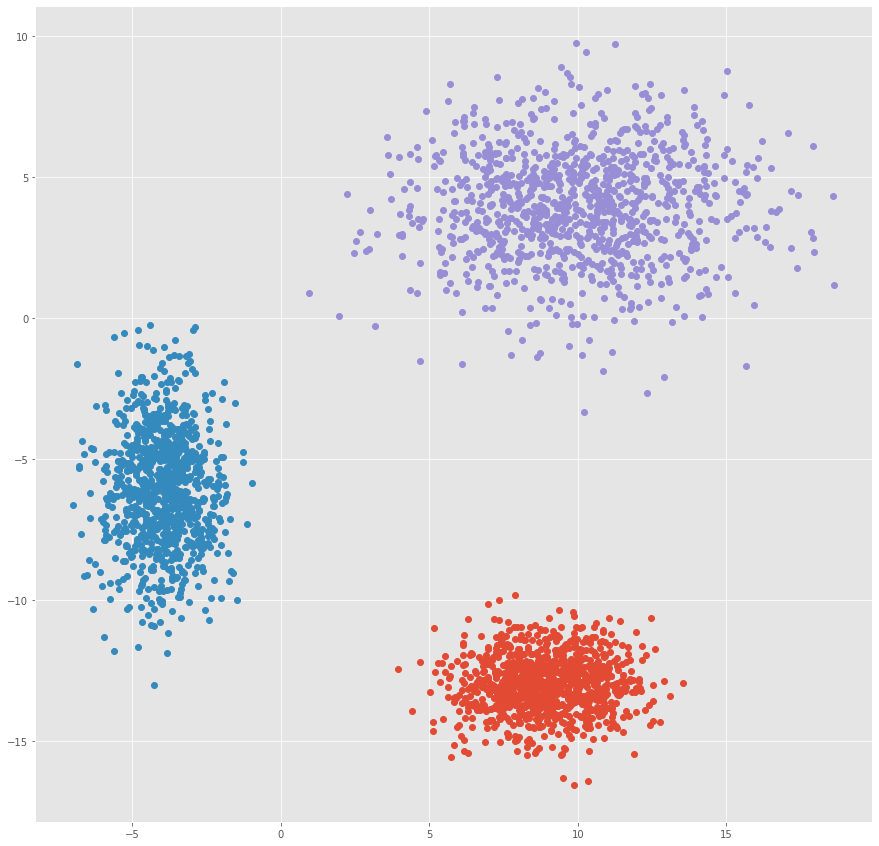

In [7]:
plt.figure(figsize=(15,15)) # налаштовуємо розміри відображення даних 
add_dots_to_plot(data_file, data_dimention, data_unique_classes)
plt.show()

# Підготовка даних для передачі в нейромережу

In [8]:
data_file = data_file.iloc[np.random.permutation(len(data_file))] # перемішування всього масиву значень з csv файлу по рядках
# можна зробити і за допомогою np.random.shuffle(dataset)

# Отримуємо всю таблицю даних з масиву pandas
dataset = data_file.values

# Вирізаємо лише стовпці з векторами
data_array = dataset[:, 0:data_dimention]
# print(data_array)

# вирізаємо стовбець з класами
data_classes = dataset[:, -1]

data_train, data_test, data_classes_train, data_classes_test = train_test_split(
    data_array,
    data_classes,
    test_size=.1
)

# print("Data classes\n{0}".format(data_classes))
# print("Data classes train\n{0}\nData classes test\n{1}".format(
#     data_classes_train,
#     data_classes_test
# ))
# print("Data_array \n{0}".format(data_train))
# print("Len of data_train {0}".format(len(data_train)))
# print("Len of data_test {0}".format(len(data_test)))

Data classes
[0. 1. 2. ... 1. 2. 1.]
Data classes train
[2. 0. 2. ... 2. 0. 0.]
Data classes test
[0. 2. 2. 2. 0. 2. 1. 2. 1. 0. 1. 2. 1. 2. 2. 2. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 2. 1. 0. 1. 0. 0. 2. 2. 2. 1. 0. 1. 0. 2. 1. 0. 2. 2. 1. 2. 1. 0. 0.
 1. 2. 0. 1. 0. 1. 2. 2. 2. 0. 0. 1. 2. 2. 1. 2. 0. 0. 0. 1. 2. 2. 0. 0.
 0. 2. 0. 1. 1. 1. 0. 2. 2. 0. 2. 2. 2. 0. 1. 1. 0. 2. 0. 2. 0. 1. 1. 2.
 1. 0. 2. 2. 0. 2. 0. 2. 2. 0. 0. 1. 0. 0. 1. 1. 1. 2. 1. 0. 1. 0. 0. 0.
 0. 2. 1. 2. 0. 0. 1. 1. 1. 1. 1. 2. 0. 2. 1. 1. 1. 1. 2. 1. 2. 1. 2. 2.
 1. 0. 2. 0. 1. 0. 0. 2. 0. 2. 2. 1. 2. 2. 2. 0. 1. 0. 1. 2. 1. 1. 2. 2.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 2. 2. 1. 1. 2. 0. 0. 0. 2. 0. 2. 2. 0. 1.
 2. 0. 1. 0. 0. 2. 1. 2. 2. 0. 2. 0. 2. 0. 1. 2. 2. 2. 1. 1. 2. 1. 1. 1.
 1. 2. 1. 1. 1. 0. 2. 0. 0. 0. 2. 2. 0. 1. 0. 1. 0. 2. 0. 1. 1. 2. 0. 1.
 0. 2. 0. 2. 2. 0. 1. 1. 1. 0. 2. 2. 1. 0. 0. 0. 0. 1. 0. 1. 0. 2. 1. 2.
 0. 0. 2. 1. 2. 2. 0. 2. 0. 1. 0. 2. 2. 0. 0. 2. 0. 2. 2. 2. 0. 1. 2. 2.
 1. 2. 0. 0. 2. 0. 1. 2. 1



---



# Нейронна мережа

Параметри налаштування ініціалізації нейронної мережі

In [9]:
input_dimention = data_dimention 
output_dimention = len(data_unique_classes) # по скільком класам буде вихід нейромережі


# Найкраще для першого набору даних
epoch_max = 150

batch_size = 128
shuffle_train = True
validation_split = .1
activation = activations.sigmoid

learning_rate = 0.1

kernel_initializer = initializers.TruncatedNormal()#RandomNormal()

patience = 20


Оптимізатор для компіляції моделі

In [10]:
# https://keras.io/optimizers/

adam = optimizers.Adam(lr=learning_rate)

# стохастичний градієнтний спуск
sgd = optimizers.SGD(lr=learning_rate, momentum=0.9)

rmsprop = optimizers.RMSprop(lr=learning_rate)

###################################################################################################
compile_optimizator = rmsprop

Створення моделі

In [11]:

model = Sequential()

model.add(Dense(
    output_dim=output_dimention,
    input_dim=input_dimention,
    activation= activation,
    kernel_initializer = kernel_initializer
))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=compile_optimizator,
    metrics=[
        'accuracy'
    ]
)

#model.summary()  # демонстрація структури моделі

C:\Users\Bloom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=2, activation=<function ..., kernel_initializer=<keras.ini..., units=3)`
  import sys


Колбеки для більшого контролю за процесом навчання

In [12]:
# https://datascience.stackexchange.com/questions/37186/early-stopping-on-validation-loss-or-on-accuracy

# якщо протягом певної кількості епох метрика не змінюватиметься,
# тобто модель почне перенавчання (overfitting), процес тренування зупиниться
early_stop = callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = patience
)

# Фінальний список колбеків для передачі у функцію тренування
callback_list = [
    callbacks.TerminateOnNaN(),
    early_stop
]

# Навчання нейронної мережі

In [13]:
history = model.fit(
    x = data_train,
    y = data_classes_train,
    epochs = epoch_max,
    batch_size = batch_size,
    shuffle = shuffle_train,
    validation_data = (data_test, data_classes_test),
    verbose = 1,
    callbacks = callback_list
)    

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2700 samples, validate on 300 samples
Epoch 1/150
2700/2700 [==============================] - 0s 75us/step - loss: 0.1890 - acc: 0.9715 - val_loss: 0.0592 - val_acc: 1.0000
Epoch 2/150
2700/2700 [==============================] - 0s 6us/step - loss: 0.0224 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 1.0000
Epoch 3/150
2700/2700 [==============================] - 0s 6us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 4/150
2700/2700 [==============================] - 0s 6us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 5/150
2700/2700 [==============================] - 0s 6us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0145 - val_acc: 1.0000
Epoch 6/150
2700/2700 [==============================] - 0s 7us/step - loss: 0.0024 - acc: 0.9996 - val_loss: 6.7102e-04 - val_acc: 1.0000
Epoch 7/150
2700/2700 [====================

Epoch 54/150
2700/2700 [==============================] - 0s 5us/step - loss: 3.3957e-07 - acc: 1.0000 - val_loss: 2.7100e-07 - val_acc: 1.0000
Epoch 55/150
2700/2700 [==============================] - 0s 6us/step - loss: 4.6433e-07 - acc: 1.0000 - val_loss: 2.7617e-07 - val_acc: 1.0000
Epoch 56/150
2700/2700 [==============================] - 0s 7us/step - loss: 3.3171e-07 - acc: 1.0000 - val_loss: 2.7617e-07 - val_acc: 1.0000
Epoch 57/150
2700/2700 [==============================] - 0s 6us/step - loss: 7.9801e-07 - acc: 1.0000 - val_loss: 2.9802e-07 - val_acc: 1.0000
Epoch 58/150
2700/2700 [==============================] - 0s 5us/step - loss: 3.1661e-07 - acc: 1.0000 - val_loss: 2.7935e-07 - val_acc: 1.0000
Epoch 59/150
2700/2700 [==============================] - 0s 6us/step - loss: 3.4125e-07 - acc: 1.0000 - val_loss: 2.9127e-07 - val_acc: 1.0000
Epoch 60/150
2700/2700 [==============================] - 0s 6us/step - loss: 3.1339e-07 - acc: 1.0000 - val_loss: 8.4517e-07 - val_acc:

2700/2700 [==============================] - 0s 6us/step - loss: 2.9639e-07 - acc: 1.0000 - val_loss: 2.4994e-07 - val_acc: 1.0000
Epoch 111/150
2700/2700 [==============================] - 0s 6us/step - loss: 2.8288e-07 - acc: 1.0000 - val_loss: 2.6902e-07 - val_acc: 1.0000
Epoch 112/150
2700/2700 [==============================] - 0s 6us/step - loss: 2.7868e-07 - acc: 1.0000 - val_loss: 2.4756e-07 - val_acc: 1.0000
Epoch 113/150
2700/2700 [==============================] - 0s 6us/step - loss: 2.6893e-07 - acc: 1.0000 - val_loss: 2.4676e-07 - val_acc: 1.0000
Epoch 114/150
2700/2700 [==============================] - 0s 6us/step - loss: 5.7586e-07 - acc: 1.0000 - val_loss: 2.6902e-07 - val_acc: 1.0000
Epoch 115/150
2700/2700 [==============================] - 0s 6us/step - loss: 2.7846e-07 - acc: 1.0000 - val_loss: 3.1034e-07 - val_acc: 1.0000
Epoch 116/150
2700/2700 [==============================] - 0s 6us/step - loss: 2.5838e-07 - acc: 1.0000 - val_loss: 2.6186e-07 - val_acc: 1.0000

-----------------------------

# Перевірка точності моделі на тестовому наборі даних

In [14]:
results = model.evaluate(data_test, data_classes_test)

print(model.metrics_names)
print(results)

300/300 [==============================] - 0s 17us/step
['loss', 'acc']
[2.463658375972955e-07, 1.0]


In [15]:
predictions = model.predict(data_test)
print(predictions)


[[1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.9998498e-01]
 [0.0000000e+00 0.0000000e+00 9.9218225e-01]
 [0.0000000e+00 0.0000000e+00 9.9106967e-01]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.9990237e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.9999398e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.9735785e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.9225795e-01]
 [0.0000000e+00 0.0000000e+00 9.9741381e-01]
 [0.0000000e+00 0.0000000e+00 9.9922019e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.000000

In [16]:
pred_transformed = transform_predictions(predictions)


for i in range(len(data_test)):
    print("----")
    print("data {0}  real class {1}  predicted class {2}".format(data_test[i], data_classes_test[i], pred_transformed[i]))


----
data [-2.07893744 -5.90382374]  real class 0.0  predicted class 0
----
data [  9.99942299 -13.24587567]  real class 2.0  predicted class 2
----
data [ 10.06332183 -10.99464814]  real class 2.0  predicted class 2
----
data [  9.36399431 -11.31450885]  real class 2.0  predicted class 2
----
data [-2.445345   -7.54437066]  real class 0.0  predicted class 0
----
data [  9.1628227  -13.02173763]  real class 2.0  predicted class 2
----
data [6.16424555 7.12567983]  real class 1.0  predicted class 1
----
data [  9.91477977 -13.61064867]  real class 2.0  predicted class 2
----
data [10.72837141  2.68850083]  real class 1.0  predicted class 1
----
data [-3.44961965 -2.18849358]  real class 0.0  predicted class 0
----
data [14.25316602  5.19751627]  real class 1.0  predicted class 1
----
data [  8.42657162 -12.24016415]  real class 2.0  predicted class 2
----
data [9.88566284 4.37818307]  real class 1.0  predicted class 1
----
data [  7.20652468 -12.49875086]  real class 2.0  predicted clas

data [9.13620457 3.53354632]  real class 1.0  predicted class 1
----
data [12.81444398  0.72547649]  real class 1.0  predicted class 1
----
data [  8.33701009 -14.02410263]  real class 2.0  predicted class 2
----
data [6.47686886 7.28030168]  real class 1.0  predicted class 1
----
data [ 10.04230663 -11.96707648]  real class 2.0  predicted class 2
----
data [11.16316904  3.3415356 ]  real class 1.0  predicted class 1
----
data [  5.14975555 -10.99288972]  real class 2.0  predicted class 2
----
data [  9.52519971 -12.84207743]  real class 2.0  predicted class 2
----
data [11.29692226  2.31163557]  real class 1.0  predicted class 1
----
data [-4.50237879 -6.16700998]  real class 0.0  predicted class 0
----
data [ 10.66915068 -12.14826743]  real class 2.0  predicted class 2
----
data [-5.02736916 -4.93178275]  real class 0.0  predicted class 0
----
data [11.03307323  2.63582958]  real class 1.0  predicted class 1
----
data [-2.79119053 -6.02145255]  real class 0.0  predicted class 0
----


---

# Візуалізація процесу навчання моделі

Виведемо список доступних метрик для відстеження

In [17]:
# продемонструємо доступні метрики для візуалізації якості навчання
# список метрик змінюватиметься в залежності від вибраних метрик на етапі компіляції моделі
for history_metric in history.history:
    print(history_metric)

val_loss
val_acc
loss
acc


Візуалізація

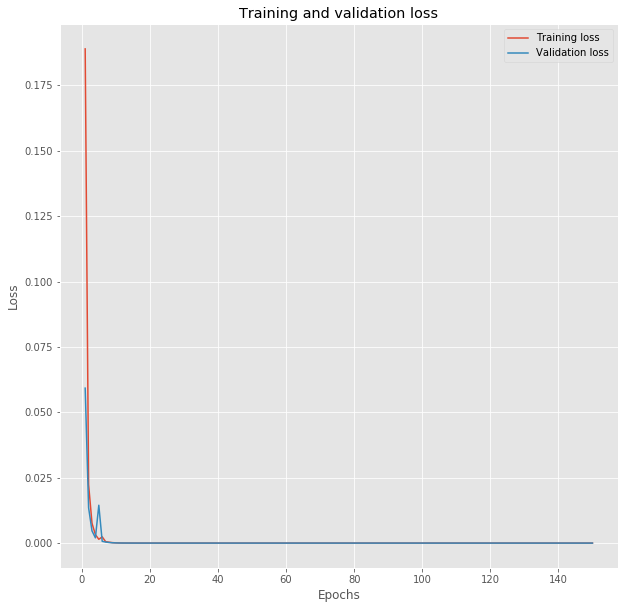

In [18]:
# Формування списків метрик для візуалізації якості навчання
loss = history.history['loss']  # наскільки точно модель 'впізнає' дані із тренувального набору
val_loss = history.history['val_loss']  # точність розпізнання даних із тестового набору

accuracy = history.history['acc']  # кількість невірно розпізнаних даних на тренувальному наборі
val_accuracy = history.history['val_acc']  # кількість невірно розпізнаних даних на тестовому наборі

epochs_passed = range(1, len(loss) + 1)  # кількість епох навчання моделі

plt.figure(figsize=(10,10))

plt.plot(epochs_passed, loss, label='Training loss')
plt.plot(epochs_passed, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

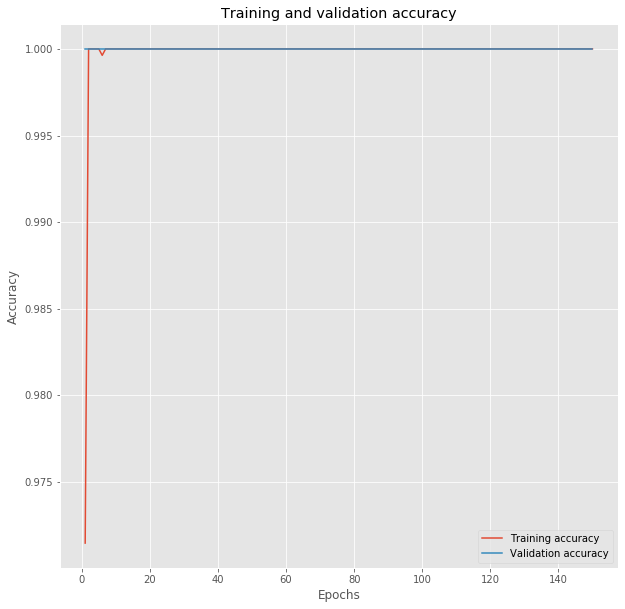

In [19]:
plt.figure(figsize=(10,10))

plt.plot(epochs_passed, accuracy, label='Training accuracy')
plt.plot(epochs_passed, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



---



# Ваги моделі

Отримуємо ваги з натренованої моделі

In [20]:
raw_weights = _get_weights_list(model)
weights = convert_weights_list(raw_weights)

for i in weights:
    print(i)
print("---------------------------------")

# конвертація вагів у зручний для роботи формат
weights = form_weights_list(weights)

for i in weights:
    print(i)


[-6.508574485778809, -4.977107048034668, -41.15967559814453]
[-7.636024475097656, 3.268735885620117, 1.4842534065246582]
[-1.2851539850234985, 4.969455718994141, -2.825617790222168]
---------------------------------
[-6.508574485778809, -7.636024475097656, -1.2851539850234985]
[-4.977107048034668, 3.268735885620117, 4.969455718994141]
[-41.15967559814453, 1.4842534065246582, -2.825617790222168]


# Візуалізація результату навчання

In [21]:
x1 = [-20,-15, -10, -5, 0, 5, 10, 15, 20]
x2_list = list(calc_trand_lines_list(x1, weights))

# for x_line in x2_list:
#     for i in range(len(x1)):
#         print(f"x1 = {x1[i]}   x2 = {x_line[i]}")
#     print("<----------->")

Візуалізуємо розділення класів даних

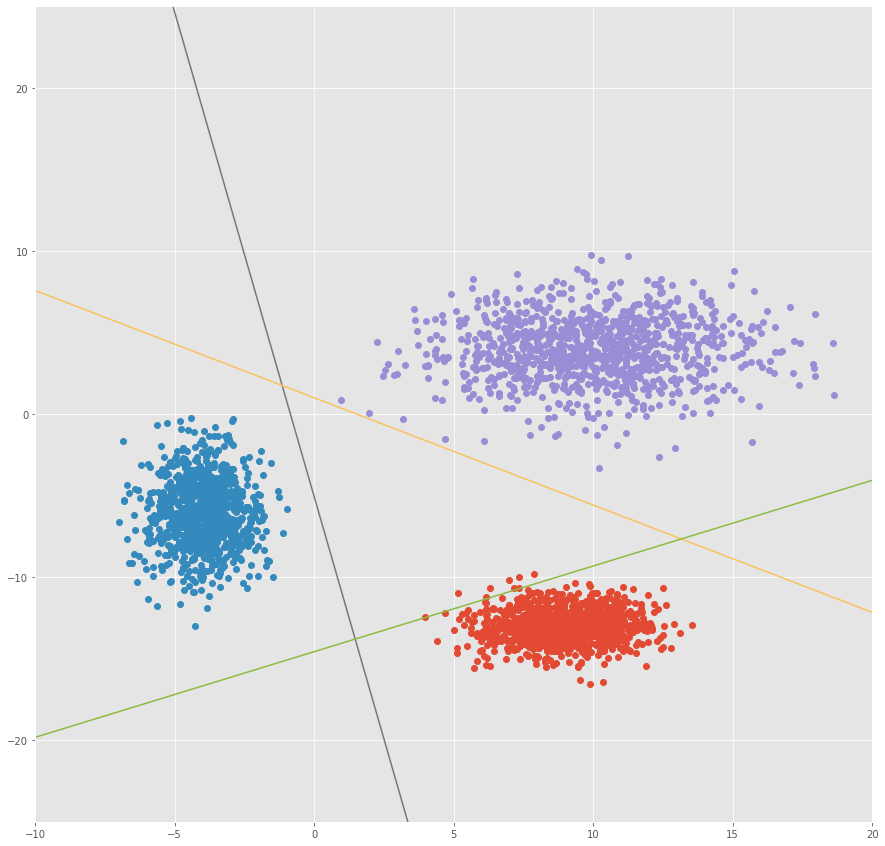

In [22]:
plt.figure(figsize=(15,15)) # налаштовуємо розміри відображення даних 
add_dots_to_plot(data_file, data_dimention, data_unique_classes)

axes = plt.gca()
axes.set_xlim([-10,20])
axes.set_ylim([-25,25])

for x2_line in x2_list:
    plt.plot(x1, x2_line)
    
plt.show()

<Figure size 1080x1080 with 0 Axes>

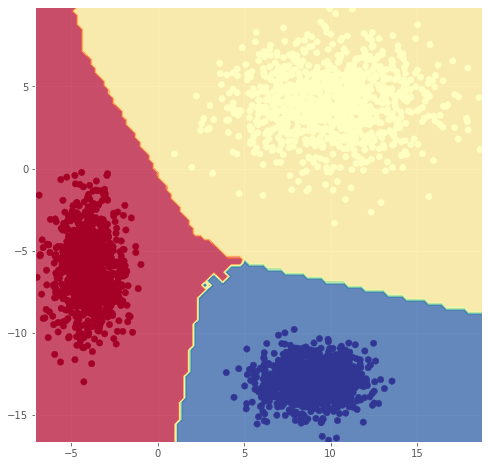

In [23]:
plt.figure(figsize=(15,15))

plot_multiclass_decision_boundary(model, data_array, data_classes)

In [24]:
## https://www.machinecurve.com/index.php/2019/07/24/why-you-cant-truly-create-rosenblatts-perceptron-with-keras/
## https://www.kaggle.com/arihant0497/try-shallow-before-going-deep
## https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

## https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

# Найкраще для першого набору даних
epoch_max = 200

batch_size = 128

shuffle_train = True

validation_split = .1

activation = activations.sigmoid

learning_rate = 0.01

kernel_initializer = initializers.TruncatedNormal()

patience = 10

Ітерація 2##

epoch_max = 500

batch_size = 128

shuffle_train = True

validation_split = .1

activation = activations.sigmoid

learning_rate = 0.1

kernel_initializer = initializers.TruncatedNormal()

patience = 20
